In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

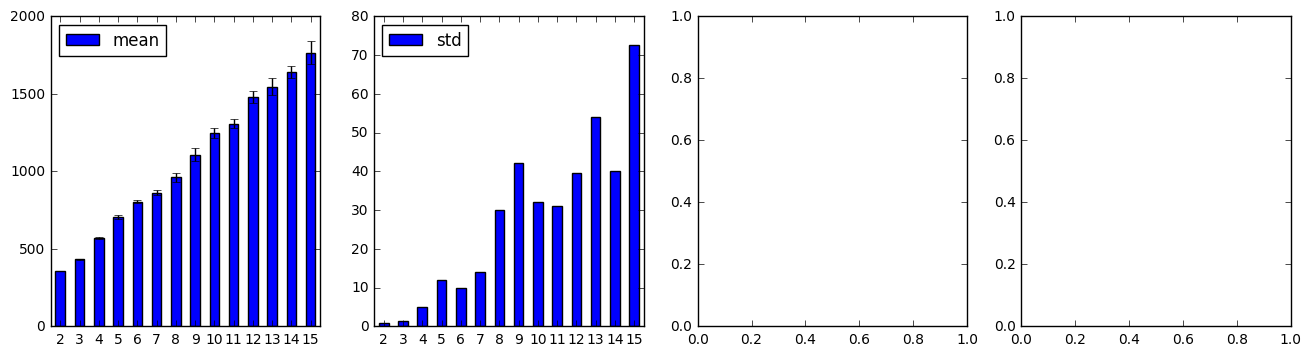

In [29]:
norm = np.mean(parse_mdtest(glob.glob("../results-cloudlab-clients1/*")))

df = pd.DataFrame(columns=["job", "mean", "std"])
for i in range(2, 16):
    d = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*"))
    #df.loc[len(df)] = [str(i), np.mean(d/norm), np.std(d/norm)]
    df.loc[len(df)] = [str(i), np.mean(d), np.std(d)]
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
df.plot.bar(ax=ax[0], y='mean', yerr='std')
x = ax[0].set_xticklabels(df['job'], rotation=0)
df.plot.bar(ax=ax[1], y='std')
x = ax[1].set_xticklabels(df['job'], rotation=0)
#df